<a href="https://colab.research.google.com/github/bharathsanjai/Melanoma-CNN-Prediction/blob/main/Melanoma_CNN_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Running on GPU

import platform
import tensorflow as tf

print("Python version: ", platform.python_version())
print("TensorFlow version: ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Running on CPU.')
else:
    print('GPU found. Running on GPU.')

Python version:  3.10.12
TensorFlow version:  2.12.0
GPU found. Running on GPU.


In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pip install keras-layer-normalization

In [73]:
## Importing all libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from glob import iglob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
# import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [74]:
# Loading images directories

root_path = '/content/drive/My Drive/CNN/Skin_cancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [19]:
print(type(data_dir_train))

<class 'pathlib.PosixPath'>


In [20]:
# files = pathlib.Path("/content/drive/My Drive/CNN/Skin_cancer").rglob("*.jpg")
# for file in files:
#     print(file)

In [75]:
image_count_train = len(list(data_dir_train.rglob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.rglob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

### Create a dataset
#### Define some parameters for the loader:

In [76]:
batch_size = 32
img_height = 180
img_width = 180

In [77]:
## Train data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [80]:
## Validation data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [79]:
## Test data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [81]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
train_ds

## Visualise the data

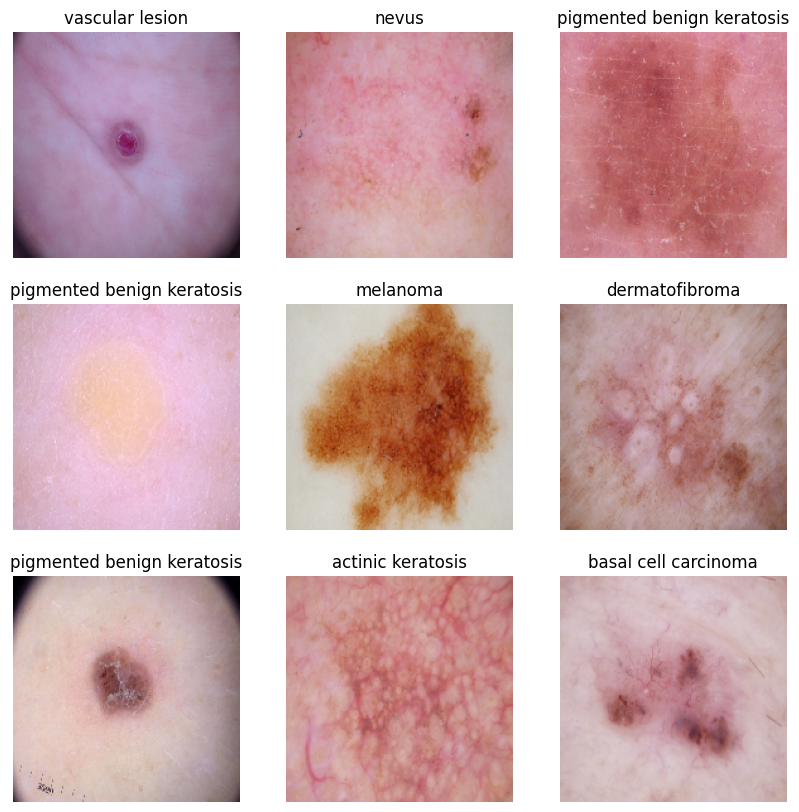

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

## Configure the dataset for performance


Dataset.cache
```
Keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
```

Dataset.prefetch

```
overlaps data preprocessing and model execution while training.
```




In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [84]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [85]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_279 (ModuleW  (None, 178, 178, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_280 (ModuleW  (None, 176, 176, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_281 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_282 (ModuleW  (None, 86, 86, 64)       18496     
 rapper)                                             

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [86]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [87]:
# View the summary of all layers
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_279 (ModuleW  (None, 178, 178, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_280 (ModuleW  (None, 176, 176, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_281 (ModuleW  (None, 88, 88, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_282 (ModuleW  (None, 86, 86, 64)       18496     
 rapper)                                             

### Train the model

In [88]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 128ms/step - loss: -79531.5391 - accuracy: 0.1719 - val_loss: -66382.4766 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: -845345.6250 - accuracy: 0.1724 - val_loss: -911497.6875 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: -3066444.2500 - accuracy: 0.1724 - val_loss: -3277462.5000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: -7476424.0000 - accuracy: 0.1724 - val_loss: -7291310.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: -14879125.0000 - accuracy: 0.1724 - val_loss: -16819694.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 67ms/step - loss: -25878174.0000 - accuracy: 0.1724 - val_loss: -29568206.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 67ms/step - los

### Visualizing training results

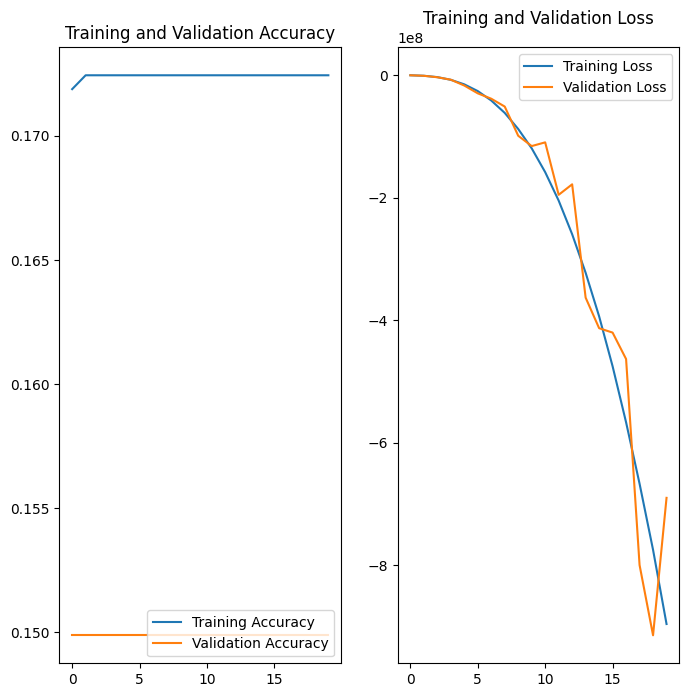

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Model Overfit or Underfit?

In [91]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)




14/14 [==============================] - 0s 19ms/step - loss: -690214784.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -672706368.0
Validation Loss -690214784.0


## Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

In [92]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
# image_class= ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

# ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
# ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


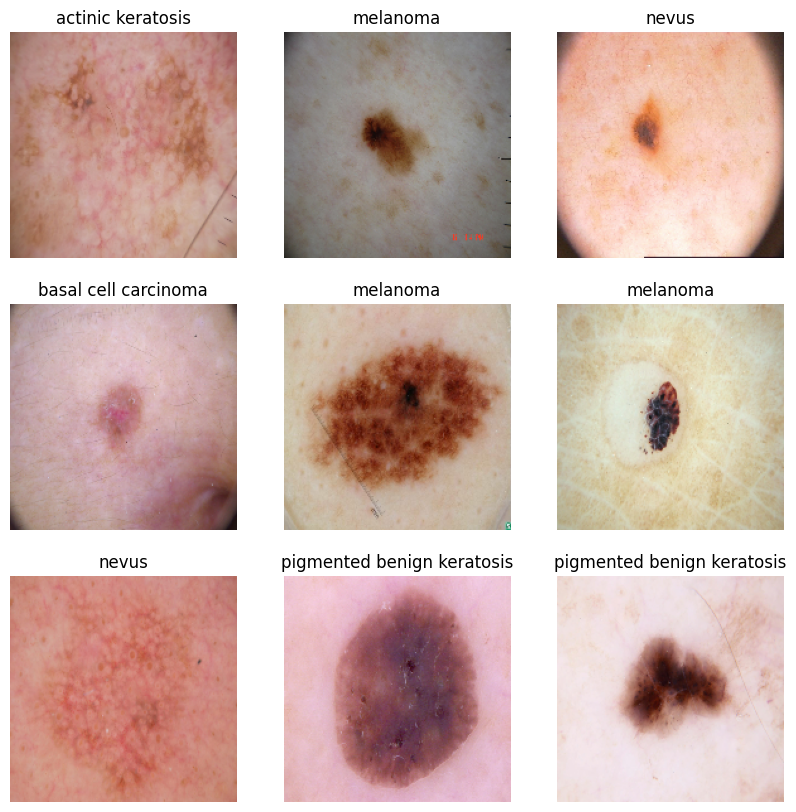

In [93]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create the model, compile and train the model

In [94]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# input_shape= input_shape=(56,56,1)
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.build(input_shape)
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_292 (ModuleW  (None, 180, 180, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_293 (ModuleW  (None, 180, 180, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_294 (ModuleW  (None, 90, 90, 32)       0         
 rapper)                                                         
                                                                 
 module_wrapper_295 (ModuleW  (None, 90, 90, 32)       0         
 rapper)                                             

### Compile the model

In [95]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [96]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Training the model

In [ ]:
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
35/35 [==============================] - 102s 3s/step - loss: 2.4158 - accuracy: 0.1849 - val_loss: 2.1863 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - 50s 1s/step - loss: 2.0366 - accuracy: 0.2041 - val_loss: 2.2134 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - 47s 1s/step - loss: 2.0252 - accuracy: 0.2005 - val_loss: 2.2480 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - 47s 1s/step - loss: 1.9811 - accuracy: 0.2099 - val_loss: 2.1686 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 5/20
35/35 [==============================] - 51s 1s/step - loss: 1.8568 - accuracy: 0.3050 - val_loss: 2.1317 - val_accuracy: 0.2288 - lr: 0.0010
Epoch 6/20
35/35 [==============================] - 46s 1s/step - loss: 1.7507 - accuracy: 0.3439 - val_loss: 2.0977 - val_accuracy: 0.1780 - lr: 0.0010
Epoch 7/20
35/35 [==============================] - 47s 1s/step - loss: 1.6727 - 

Visualize the model results

<built-in method keys of dict object at 0x7fc495d13000> :


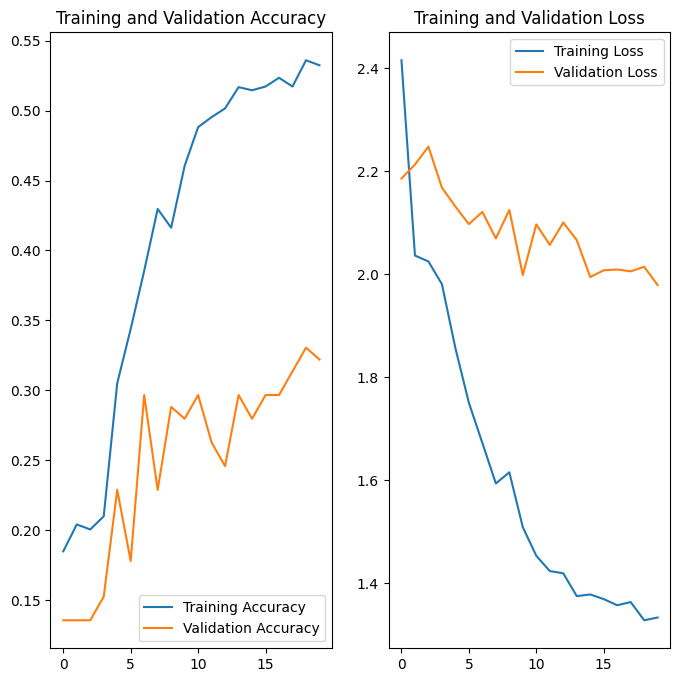

In [99]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [102]:
# loss, accuracy = model.evaluate(train_ds, verbose=1)
# loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

# print("Accuracy: ", accuracy)
# print("Validation Accuracy: ",accuracy_v)
# print("Loss: ",loss)
# print("Validation Loss", loss_v)

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Inference: Model has some improvements post adding dropout but still there is scope to recue the overfit by adding augumentation libraries

Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

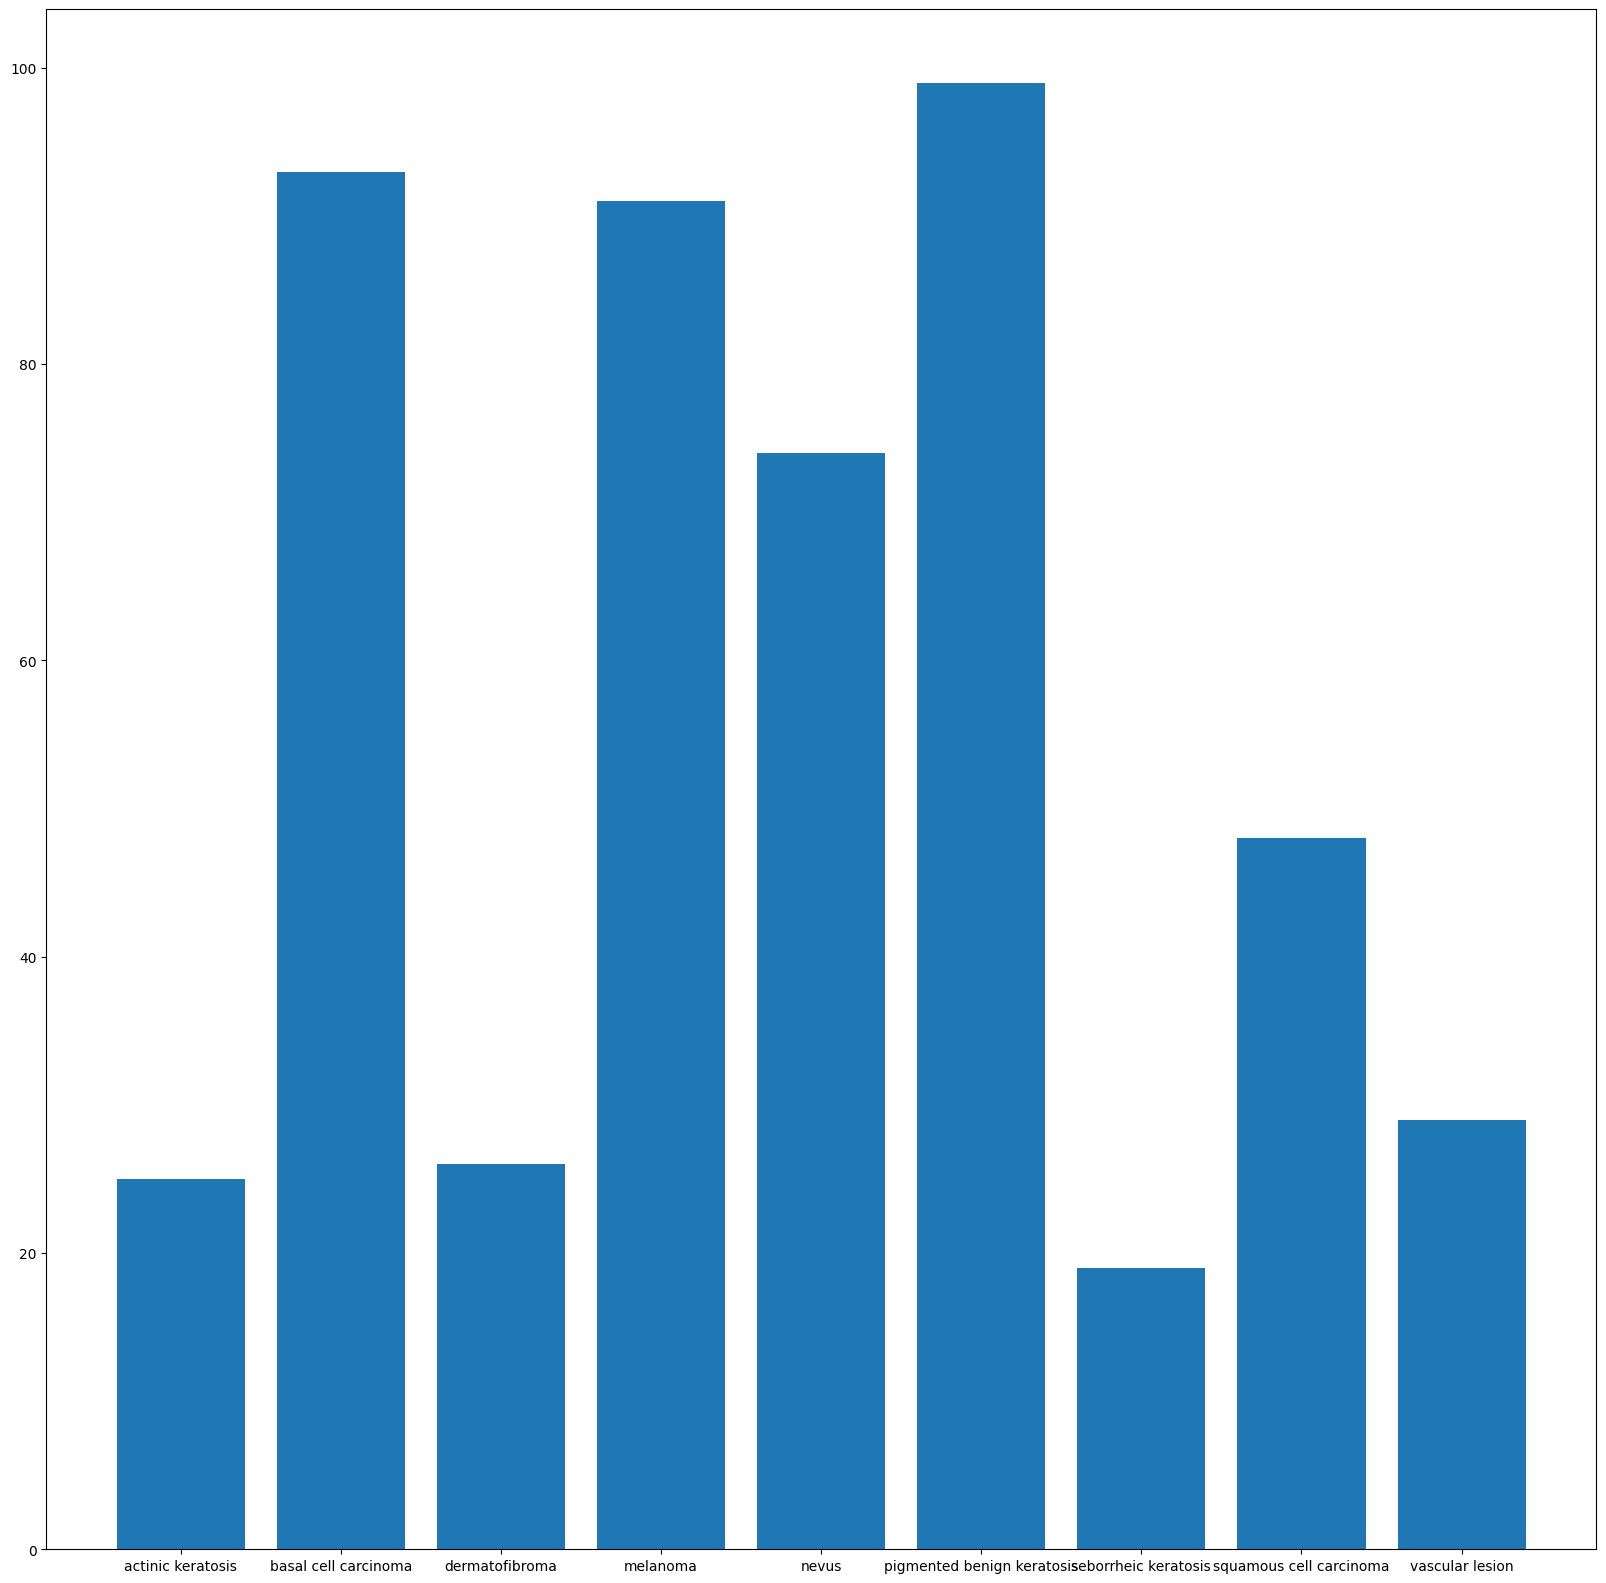

In [103]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- Which class has the least number of samples? - Actinic Keratosos and Seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training

In [104]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:



*   Instantiate a Pipeline object pointing to a directory containing your initial 1.image data set.
*   Define a number of operations to perform on this data set using your Pipeline object.
*   Execute these operations by calling the Pipeline’s sample() method

In [112]:
path_to_training_dataset="/content/drive/My Drive/CNN/Skin_cancer/Train/"

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
# i= 'actinic keratosis';
# p = Augmentor.Pipeline(path_to_training_dataset+i)

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A2E4A530>: 100%|██████████| 500/500 [00:17<00:00, 28.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A42EE410>: 100%|██████████| 500/500 [00:17<00:00, 28.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC4A40D4D60>: 100%|██████████| 500/500 [00:19<00:00, 25.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC5D644AEC0>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC495CF4280>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC5311ADF30>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC5D644A7D0>: 100%|██████████| 500/500 [00:39<00:00, 12.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A45F8100>: 100%|██████████| 500/500 [00:17<00:00, 28.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC5D644ABF0>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


In [113]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.


In [114]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_8ed0d13e-35f4-4f18-9668-893ef41e9f64.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033891.jpg_b0e70ab4-9c7d-4572-b548-fa3cc0f97352.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_286273b3-818c-4cc3-a03e-2f1e006d5160.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030579.jpg_b8d695c7-7991-437f-815a-ebe9a574e040.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_1acd3be2-a403-420c-8188-a3ba182f5063.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032613.jpg_94009a6a-df10-4e3b-bc5d-19d61a89e259.jpg',
 '/content/drive/My Drive/CNN/Skin_cancer/Train/dermatofibroma/output/dermat

In [115]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [116]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [117]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [118]:
new_df['Label'].value_counts()

dermatofibroma                500
nevus                         500
vascular lesion               500
melanoma                      500
squamous cell carcinoma       500
seborrheic keratosis          500
basal cell carcinoma          500
actinic keratosis             500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [119]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [120]:
data_dir_train="/content/drive/My Drive/CNN/Skin_cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


Create a validation dataset

In [121]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [124]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

# model.build(input_shape)

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_337 (ModuleW  (None, 180, 180, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_338 (ModuleW  (None, 180, 180, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_339 (ModuleW  (None, 90, 90, 32)       0         
 rapper)                                                         
                                                                 
 batch_normalization_14 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                    

Compile your model (Choose optimizer and loss function appropriately)

In [125]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [126]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 48s 250ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 42s 241ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 42s 240ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1337
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 42s 240ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 41s 239ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-04
Epoch 6/50
1

Visualize the model results

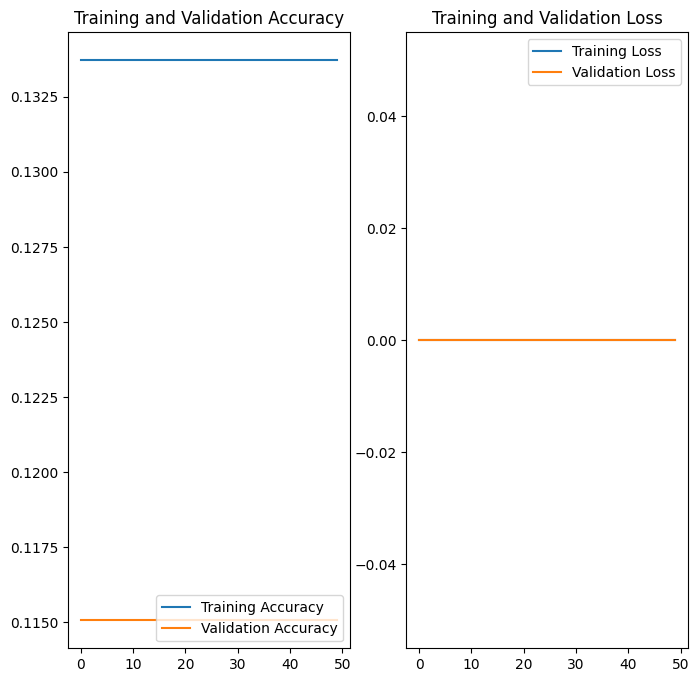

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Did you get rid of underfitting/overfitting? Did class rebalance help?

The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward